In [105]:
# disable compiler warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# imports 
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Dense
from typing import List
import datetime

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


2022-12-07 18:36:08.871883: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


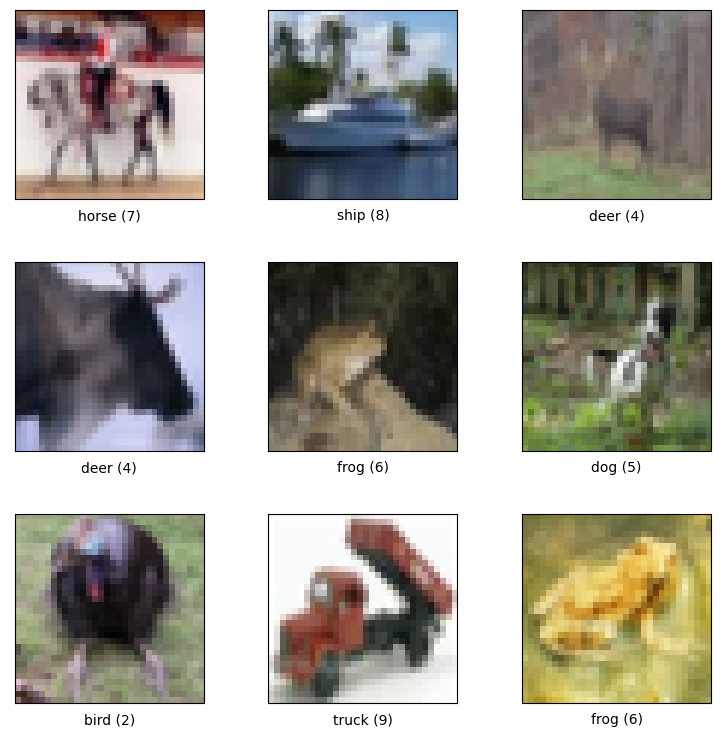

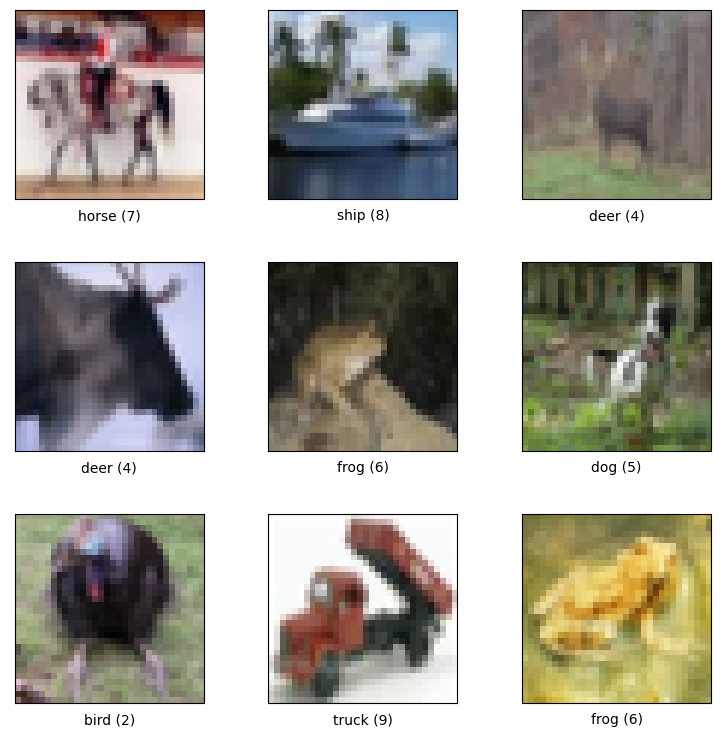

In [106]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
(train_ds_global, test_ds_global), ds_info = tfds.load("cifar10" , split =["train", "test"] , as_supervised=True , with_info=True)

def prepare_mnist_data(mnist):
  #convert data from uint8 to float32
  mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
  
  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
  mnist = mnist.map(lambda img, target: ((img/128.)-1., target))

  #create one-hot targets
  mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  mnist = mnist.cache()

  #shuffle, batch, prefetch
  mnist = mnist.shuffle(1000)
  mnist = mnist.batch(32)
  mnist = mnist.prefetch(20)
  
  #return preprocessed dataset
  return mnist


train_dataset = train_ds_global.apply(prepare_mnist_data)
test_dataset = test_ds_global.apply(prepare_mnist_data)

tfds.show_examples(train_ds_global, ds_info)

In [107]:
class BasicConv(tf.keras.Model):
    def __init__(self):
        super(BasicConv, self).__init__()

        self.loss_function = tf.keras.losses.CategoricalCrossentropy()
        self.metrics_list = [tf.keras.metrics.Accuracy(name="Accuracy"),
                             tf.keras.metrics.Mean(name="loss"),
                             tf.keras.metrics.Mean(name="total_frobenius_norm")]

        self.optimizer = tf.keras.optimizers.Adam()

        self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()

        self.out = tf.keras.layers.Dense(10, activation='softmax')

    @tf.function
    def call(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.pooling(x)
        x = self.convlayer3(x)
        x = self.convlayer4(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x

    # 3. metrics property
    @property
    def metrics(self):
        return self.metrics_list
        # return a list with all metrics in the model



    # 4. reset all metrics objects
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()



    def compute_frobenius(self):
        frobenius_norm = tf.zeros((1,))
        for var in self.trainable_variables:
            frobenius_norm += tf.norm(var, ord="euclidean")
        return frobenius_norm



    # train_step method
    @tf.function
    def train_step(self, data):
        img, label = data
        
        # compute output and loss, train the variables
        with tf.GradientTape() as tape:
            output = self(img, training=True)
            loss = self.loss_function(label, output)
            
        # update trainable variables
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # update metrics
        self.metrics_list[0].update_state(tf.argmax(output, axis=1), tf.argmax(label, axis=1))
        self.metrics_list[1].update_state(loss)
        self.metrics_list[2].update_state(self.compute_frobenius())
        
        # return a dict with metric information
        return {m.name : m.result() for m in self.metrics_list}



    # test_step method
    @tf.function
    def test_step(self, data):
        img, label = data

        # compute output and loss, without training
        output = self(img, training=False)
        loss = self.loss_function(label, output)

        # update metrics
        self.metrics_list[0].update_state(tf.argmax(output, axis=1), tf.argmax(label, axis=1))
        self.metrics_list[1].update_state(loss)
        self.metrics_list[2].update_state(self.compute_frobenius())

        # return a dict with metric information 
        return {m.name : m.result() for m in self.metrics_list}

In [108]:

def create_summary_writers(config_name):
    
    # Define where to save the logs
    # along with this, you may want to save a config file with the same name so you know what the hyperparameters were used
    # alternatively make a copy of the code that is used for later reference
    
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    train_log_path = f"logs/{config_name}/{current_time}/train"
    val_log_path = f"logs/{config_name}/{current_time}/val"

    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)

    # log writer for validation metrics
    val_summary_writer = tf.summary.create_file_writer(val_log_path)
    
    return train_summary_writer, val_summary_writer

train_summary_writer, val_summary_writer = create_summary_writers(config_name="RUN1")

In [109]:
# trains the model by iterating through the dataset and applying training_step method epochs time
def training_loop(model, train_ds, epochs, train_summary_writer, memory):
    # iterate over epochs
    for epoch in range(epochs):
        print(f"epoch: {epoch}")

        # train steps on all batches in the training data
        for (img, label) in train_ds:
            metrics = model.train_step((img, label))
            
            # keep data in summary with metrics
            with train_summary_writer.as_default():
                for metric in model.metrics_list:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        for (key, value) in metrics.items():
            memory[key].append(value.numpy())
            print(f"{key} : {value.numpy()}")

        model.reset_metrics()
        
    return memory


# tests overall performance of model
def test_loop(model, test_ds, val_summary_writer, memory):
    # test steps on every item in test dataset
    for (img, label) in test_ds:
        metrics = model.test_step((img, label))
        
        # keep data with metrics
        with val_summary_writer.as_default():
            for metric in model.metrics_list:
                tf.summary.scalar(f"{metric.name}", metric.result(), step=1)

    for (key, value) in metrics.items():
        memory[key].append(value.numpy())
        print(f"{key} : {value.numpy()}")

    model.reset_metrics()

    return memory

In [110]:
basic_model = BasicConv()

memory_test1 = {"Accuracy" : [], "loss" : [], "total_frobenius_norm" : []}

test_loop(basic_model,
        test_ds=test_dataset,
        val_summary_writer=val_summary_writer,
        memory=memory_test1)

print("test_loop: ")
print(memory_test1)
print("\n")

memory_train1 = {"Accuracy" : [], "loss" : [], "total_frobenius_norm" : []}
training_loop(basic_model,
              train_ds=train_dataset,
              epochs=10,
              train_summary_writer=train_summary_writer,
              memory=memory_train1)

print("test_loop: ")
print(memory_train1)
print("\n")

memory_test2 = {"Accuracy" : [], "loss" : [], "total_frobenius_norm" : []}
test_loop(basic_model,
        test_ds=test_dataset,
        val_summary_writer=val_summary_writer,
        memory=memory_test2)


print("test_loop: ")
print(memory_test2)

Accuracy : 0.10000000149011612
loss : 2.303284168243408
total_frobenius_norm : 23.931127548217773
test_loop: 
{'Accuracy': [0.1], 'loss': [2.3032842], 'total_frobenius_norm': [23.931128]}


epoch: 0
Accuracy : 0.3681600093841553
loss : 1.6950976848602295
total_frobenius_norm : 30.763273239135742
epoch: 1
Accuracy : 0.5081599950790405
loss : 1.3629071712493896
total_frobenius_norm : 40.759124755859375
epoch: 2
Accuracy : 0.5722200274467468
loss : 1.201082706451416
total_frobenius_norm : 47.821327209472656
epoch: 3
Accuracy : 0.6055799722671509
loss : 1.1139490604400635
total_frobenius_norm : 53.073726654052734
epoch: 4
Accuracy : 0.6296399831771851
loss : 1.0449248552322388
total_frobenius_norm : 57.594730377197266
epoch: 5
Accuracy : 0.649399995803833
loss : 0.99211585521698
total_frobenius_norm : 61.871726989746094
epoch: 6
Accuracy : 0.6642799973487854
loss : 0.948866605758667
total_frobenius_norm : 66.0821304321289
epoch: 7
Accuracy : 0.6796000003814697
loss : 0.90477055311203
total

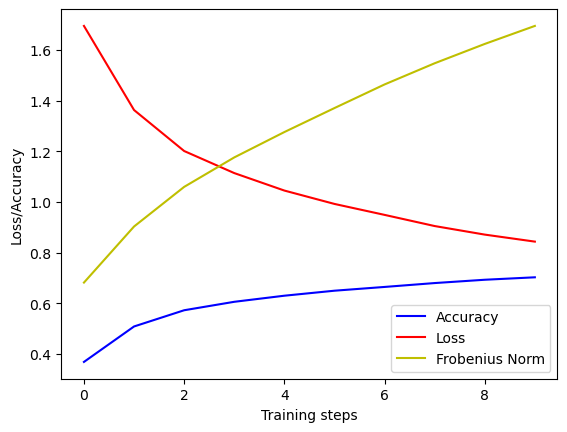

In [111]:
# visualize accuracy, loss and frobenius norm
def visualization(accuracies, losses, frobenius):
    plt.figure()
    line1, = plt.plot(accuracies, "b")
    line2, = plt.plot(losses, "r" )

    frob_new = frobenius/np.max(frobenius) * np.max(losses)
    line3, = plt.plot(frob_new, "y" )

    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1, line2, line3),("Accuracy", "Loss", "Frobenius Norm"))
    plt.show()

visualization(memory_train1["Accuracy"], memory_train1["loss"], memory_train1["total_frobenius_norm"])

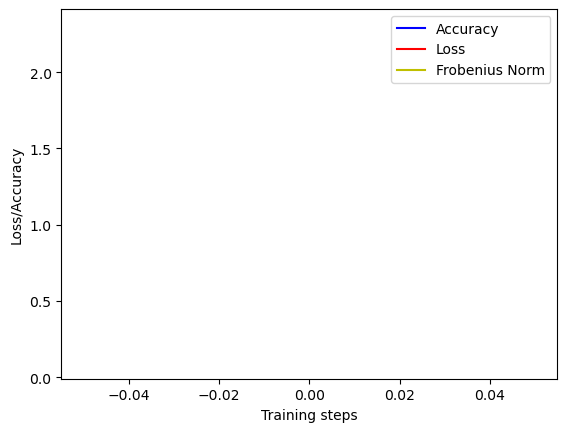

In [112]:
visualization(memory_test1["Accuracy"], memory_test1["loss"], memory_test1["total_frobenius_norm"])

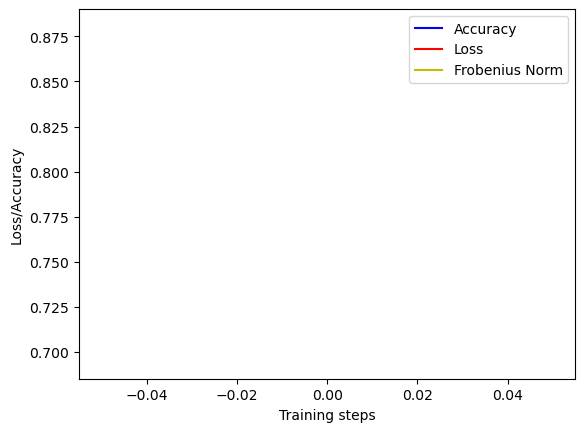

In [113]:
visualization(memory_test2["Accuracy"], memory_test2["loss"], memory_test2["total_frobenius_norm"])